## Reading in packages, data

In [43]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            classification_report, precision_recall_curve, log_loss, accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn import preprocessing

In [44]:
spotify_df = pd.read_csv('3classspotifytracks.csv')

In [45]:
spotify_df.drop(['target', 'Unnamed: 0'], axis=1, inplace=True)

## Train/Val/Test split

In [46]:
X = np.array(spotify_df.iloc[:, 4:-1])
y = np.array(spotify_df.genre)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Train and Val scores

In [49]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, y_train)

RandomForestClassifier()

In [77]:
y_train_pred = randomforest.predict(X_train)
y_val_pred = randomforest.predict(X_val)

In [80]:
accuracy = metrics.accuracy_score(y_train, y_train_pred)
precision = metrics.precision_score(y_train, y_train_pred, average = 'macro')
recall = metrics.recall_score(y_train, y_train_pred, average = 'macro')
f1 = metrics.f1_score(y_train, y_train_pred, average = 'macro')

print("Training Set Accuracy:" , round(accuracy, 3))
print("Training Set Precision:", round(precision, 3))
print("Training Set Recall:", round(recall, 3))
print("Training Set F1 Score:", round(f1, 3))

Training Set Accuracy: 1.0
Training Set Precision: 1.0
Training Set Recall: 1.0
Training Set F1 Score: 1.0


In [81]:
accuracy = metrics.accuracy_score(y_val, y_val_pred)
precision = metrics.precision_score(y_val, y_val_pred, average='macro')
recall = metrics.recall_score(y_val, y_val_pred, average='macro')
f1 = metrics.f1_score(y_val, y_val_pred, average='macro')

print("Val Set Accuracy:" , round(accuracy, 3))
print("Val Set Precision:", round(precision, 3))
print("Val Set Recall:", round(recall, 3))
print("Val Set F1 Score:", round(f1, 3))

Val Set Accuracy: 0.884
Val Set Precision: 0.884
Val Set Recall: 0.884
Val Set F1 Score: 0.884


## Confusion Matrix, ROC AUC score, Log loss

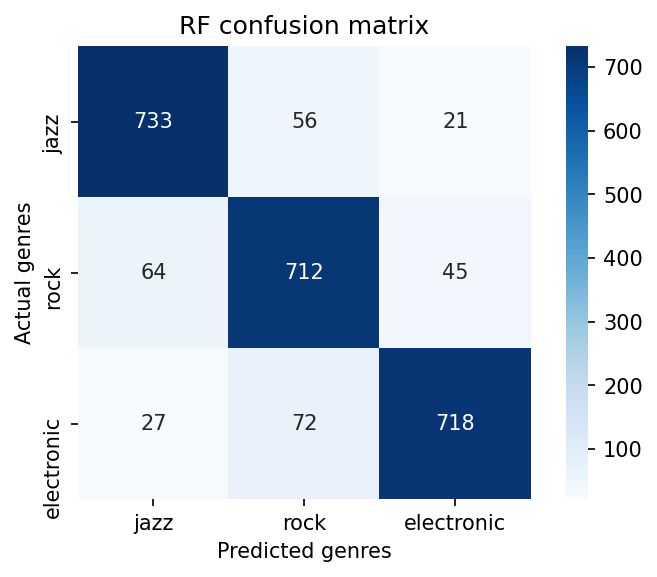

In [82]:
randomforest_confusion = confusion_matrix(y_val, randomforest.predict(X_val))
plt.figure(dpi=150)

sns.heatmap(randomforest_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['jazz', 'rock', 'electronic'],
           yticklabels=['jazz', 'rock', 'electronic']);

plt.xlabel('Predicted genres')
plt.ylabel('Actual genres')
plt.title('RF confusion matrix');

In [14]:
print("ROC AUC score:", roc_auc_score(y_val, randomforest.predict_proba(X_val), multi_class="ovo"))

ROC AUC score: 0.9717841071905791


In [90]:
print("Log-loss on RF: {:6.4f}".format(log_loss(y_val, randomforest.predict_proba(X_val))))

Log-loss on RF: 0.3583


# XGBoost

In [50]:
y_train_xgb = pd.DataFrame(data= y_train)
y_val_xgb = pd.DataFrame(data= y_val)
y_test_xgb = pd.DataFrame(data= y_test)

In [51]:
le = preprocessing.LabelEncoder()
le.fit(y_train_xgb)

/usr/local/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [52]:
y_train_xgb = le.transform(y_train_xgb)
y_val_xgb = le.transform(y_val_xgb)
y_test_xgb = le.transform(y_test_xgb)

In [53]:
y_val_xgb

array([1, 1, 2, ..., 2, 2, 0])

In [ ]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, 
                       max_depth=5,
                       objective="multi:softmax",  
                       learning_rate=.1, 
                       subsample=0.8,
                       min_child_weight=12,
                       colsample_bytree=.7,
                       n_jobs=-1,
                       num_class=3, 
                       )

eval_set=[(X_train,y_train_xgb),(X_val,y_val_xgb)] -

fit_model = gbm.fit( 
                    X_train, y_train_xgb, 
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=30,
                    verbose=True -
                    )

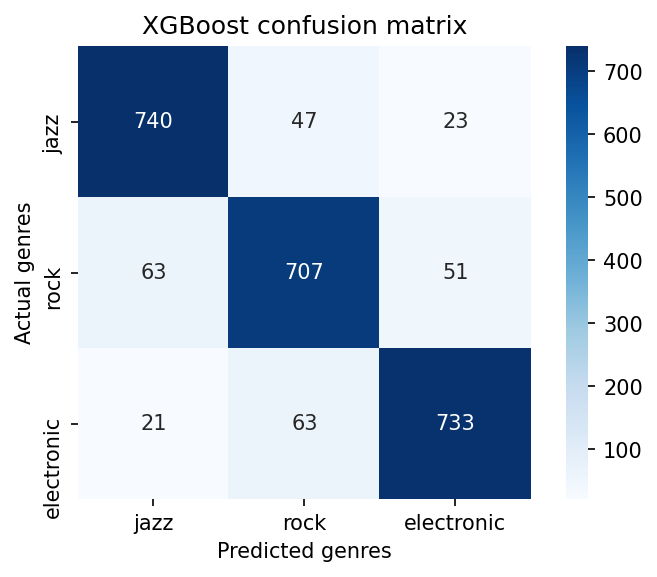

In [86]:
xgb_confusion = confusion_matrix(y_val_xgb, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))
plt.figure(dpi=150)

sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['jazz', 'rock', 'electronic'],
           yticklabels=['jazz', 'rock', 'electronic']);

plt.xlabel('Predicted genres')
plt.ylabel('Actual genres')
plt.title('XGBoost confusion matrix');

In [126]:
y_train_preds = gbm.predict(X_train)
y_val_preds = gbm.predict(X_val)
y_test_preds = gbm.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train_xgb, y_train_preds)
val_accuracy = metrics.accuracy_score(y_val_xgb, y_val_preds)
test_accuracy = metrics.accuracy_score(y_test_xgb, y_test_preds)

print("Train Accuracy:" , round(train_accuracy, 3))
print("Val Accuracy:" , round(val_accuracy, 3))
#not the right way to grab test score
print("Test Accuracy:" , round(test_accuracy, 3))

Train Accuracy: 0.936
Val Accuracy: 0.891
Test Accuracy: 0.877


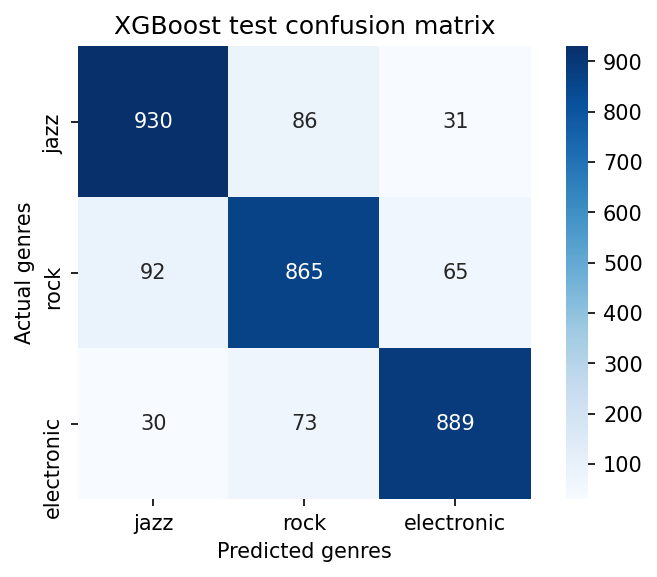

In [127]:
xgb_confusion = confusion_matrix(y_test_xgb, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))
plt.figure(dpi=150)

sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['jazz', 'rock', 'electronic'],
           yticklabels=['jazz', 'rock', 'electronic']);

plt.xlabel('Predicted genres')
plt.ylabel('Actual genres')
plt.title('XGBoost test confusion matrix');

In [128]:
print(classification_report(y_test_xgb, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1047
           1       0.84      0.85      0.85      1022
           2       0.90      0.90      0.90       992

    accuracy                           0.88      3061
   macro avg       0.88      0.88      0.88      3061
weighted avg       0.88      0.88      0.88      3061



## Feature Importance

In [69]:
X_val_df = pd.DataFrame(X_val)

In [89]:
pd.DataFrame({'col_name': gbm.feature_importances_}, index = ['length', 'popularity', 
          'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 
          'instrumentalness', 'liveness', 'valence', 'tempo','time_signature']) \
            .sort_values(by='col_name', ascending=False)

,col_name
acousticness,0.231852
danceability,0.123197
instrumentalness,0.106403
tempo,0.077015
energy,0.072847
popularity,0.071823
loudness,0.059606
valence,0.057499
mode,0.053704
speechiness,0.044376


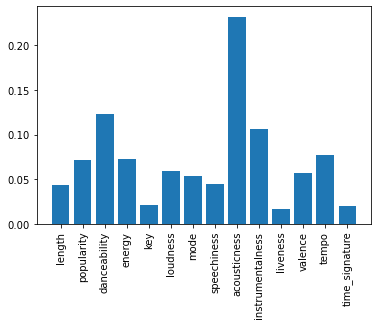

In [123]:
plt.bar(range(len(gbm.feature_importances_)), gbm.feature_importances_)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13], ['length', 'popularity', 
          'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 
          'instrumentalness', 'liveness', 'valence', 'tempo','time_signature'], rotation = 90);